Recommendations based on descriptions similarity can be used for people without accounts as well.

In [1]:
%pylab inline

# Plotting
import matplotlib.pyplot as plt

import numpy as np
import sqlite3
import pandas as pd

import utilities as util

# NLP
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

# Similarity measure
from sklearn.metrics.pairwise import cosine_similarity

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib


# Useful functions

In [2]:
def print_vectorized_description(i, df_items, vectorizer, X):
    """Print the original and vectorized versions of a route description.
    """
    print df_items.loc[i, 'route_name']
    print ''
    print df_items.loc[i, 'description']
    print ''
    
#     # Tokenized version of description
#     analyze = vectorizer.build_analyzer()
#     text = df_items.loc[i, 'description']
#     print ' '.join(analyze(text))
#     print ''
    
    words = vectorizer.get_feature_names()
    tfidf = X.toarray()[i]
    df_words = pd.DataFrame(data={'words':words, 'tfidf':tfidf})
    # Get nonzero TFIDF words, then sort in descending order 
    top_words = df_words[df_words['tfidf']>0].sort_values('tfidf', ascending=False)
    print top_words['words'].values

In [3]:
def most_similar_routes(i, df_items, cosine_similarities, n=5):
    """Get the n routes most similar to route i ranked by similarity.
    """
    df_sim = df_items.copy()
    df_sim['similarity'] = cosine_similarities[i, :]
    df_top = df_sim.sort_values('similarity', ascending=False)[:n]
    
    # print routes
    columns = ['iid', 'route_name', 'difficulty', 'pitches', 'length', 'similarity']
    display(df_top[columns])
    
    for j in range(len(df_top)):
        print df_top.iloc[j]['route_name']
        print df_top.iloc[j]['route_url']
        print df_top.iloc[j]['similarity']
        print df_top.iloc[j]['description']
        print ''
        
    return df_top

# Load data

In [4]:
filename = '../data/mountain_project_gunks.sqlite'
conn = sqlite3.connect(filename)

# Route data
df_items = pd.read_sql("""
SELECT items.*, pro.pro_type
FROM items JOIN pro 
ON items.pro_id = pro.id
""", conn)

In [9]:
df_items.drop('description', axis=1).head(3).style.format(util.make_clickable, subset=['route_url'])

,iid,route_name,route_url,difficulty,pro_id,length,pitches,nratings,monthly_views,total_views,pro_type
0,0,Sudoriferous,https://www.mountainproject.com/route/108300801/sudoriferous,5.2,1,120,2,7,19,1309,Trad
1,1,Cordelette Arete,https://www.mountainproject.com/route/112109817/cordelette-arete,5.2,1,80,1,12,38,1161,Trad
2,2,69,https://www.mountainproject.com/route/106133868/69,5.3,1,50,1,59,36,4727,Trad


In [12]:
print(df_items['description'].head(3).values)

[u"Pitch 1: Climb the face just next to the huge left-facing corner (feel free to use the corner blocks if it helps), past a huge roof. Top out above the roof and traverse right about 20 feet to a tree which you can use as your anchor. Dick Williams gives this pitch 5.1 PG, I'd grade it more like 5.3! There's a little crux about halfway up, and near the top you kind of have to haul yourself up onto a flake. But maybe I missed something obvious.   Pitch 2: At the wall behind your tree anchor, you'll see a broken corner. Currently there's a tree which gets in your face as you climb this. Go up the corner about 20 feet until you meet a ledge. Walk/crawl left about 10 feet until the ledge meets a corner. Turn (climber's) left around the corner, look up and right - you'll see a fairly clean, white ramp. Follow the ramp up. From here it looks like you could easily go up left to top out. But the climbing looked more fun going right, which is what I did: walk up to a right-facing corner, step 

# Find similar climbing routes based on text description
 * Text tokenized with TFIDF.
 * Cosine similarity used to rand most similar routes

In [6]:
stopwords_list = stopwords.words('english')
print(stopwords_list)

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [7]:
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.01,
                     max_df=1.0,
                     max_features=300,
                     stop_words=stopwords_list)

##### Vectorize the route text descriptions ####
descriptions = df_items['description'].tolist()

# Tokenize and build vocab from the descriptions
vectorizer.fit(descriptions)
# Transform the descriptions to vectors
X = vectorizer.transform(descriptions)

# Find the most similar routes
cosine_similarities = cosine_similarity(X)

# The chosen words
print vectorizer.get_feature_names()

[u'10', u'10 feet', u'100', u'15', u'15 feet', u'20', u'20 feet', u'25', u'30', u'40', u'50', u'60', u'60m', u'70', u'80', u'access', u'access trail', u'aiming', u'also', u'anchor', u'anchors', u'angle', u'another', u'area', u'arete', u'around', u'around corner', u'arrow', u'back', u'base', u'begin', u'behind', u'belay', u'belay ledge', u'belay rap', u'belay tree', u'best', u'better', u'big', u'bit', u'block', u'blocks', u'bolt', u'bolt anchor', u'bolted', u'bolted anchor', u'bolts', u'book', u'boulder', u'broken', u'bulge', u'carriage', u'carriage road', u'ceiling', u'chimney', u'classic', u'clean', u'cliff', u'clifftop', u'climb', u'climb corner', u'climb crack', u'climb face', u'climb left', u'climb right', u'climb straight', u'climbed', u'climber', u'climbers', u'climbing', u'climbs', u'continue', u'corner', u'corner climb', u'could', u'couple', u'crack', u'cracks', u'crux', u'decent', u'descend', u'descent', u'diagonal', u'dick', u'dick williams', u'difficult', u'dihedral', u'dire

In [8]:
# Example of vectorized text
i = 123
print_vectorized_description(i, df_items, vectorizer, X)

Shockley's Ceiling

This route is considered to be one of the top three 5.6 routes at the Gunks, with High E and Madame G being the other two.  The first two pitches can be linked up with Strictly From Nowhere - climb past the first roof of Strictly, and make a traverse right to the belay just below the Shockley's roof.  P1 and P2 can easily be combined.   The Shockley's access trail is located almost exactly where the East Trapps Connector Trail (the Stairmaster) meets the carriage road.  This is about a 5-min. walk from the Uberfall.   P1: Start 25' right and uphill from Strictly in a large right-facing dihedral.  Follow a chimney (or climb the face to the left) to an awkward step around a roof. 5.4, 50'.   P2: Angle up and right into a steep right-facing corner.  Follow fun jugs to a lichen-y slab finish.  Belay on the large ledge below the roofs. 5.5, 120'.   P3: The money pitch: Jam the hand crack through the roof.  After making the crux move, place some gear for your 2nd.  Contin

In [9]:
i = 123
#i = 272
#i = 402
#i = 310
#i = 446
df_top = most_similar_routes(i, df_items, cosine_similarities, n=5)

,iid,route_name,difficulty,pitches,length,similarity
123,123,Shockley's Ceiling,5.6,3,275,1.000000
96,96,Drunkard's Delight,5.8-,2,180,0.549877
152,152,Something Interesting,5.7+,2,200,0.523845
207,207,Friends and Lovers,5.9,3,230,0.521931
323,323,Bonnie's Roof,5.9,2,250,0.490327


Shockley's Ceiling
https://www.mountainproject.com/route/105799687/shockleys-ceiling
1.0000000000000002
This route is considered to be one of the top three 5.6 routes at the Gunks, with High E and Madame G being the other two.  The first two pitches can be linked up with Strictly From Nowhere - climb past the first roof of Strictly, and make a traverse right to the belay just below the Shockley's roof.  P1 and P2 can easily be combined.   The Shockley's access trail is located almost exactly where the East Trapps Connector Trail (the Stairmaster) meets the carriage road.  This is about a 5-min. walk from the Uberfall.   P1: Start 25' right and uphill from Strictly in a large right-facing dihedral.  Follow a chimney (or climb the face to the left) to an awkward step around a roof. 5.4, 50'.   P2: Angle up and right into a steep right-facing corner.  Follow fun jugs to a lichen-y slab finish.  Belay on the large ledge below the roofs. 5.5, 120'.   P3: The money pitch: Jam the hand crack 

# Cluster routes and project onto 2 dimensions

## Choose optimal number of clusters then cluster

2 3 4 5 6 7 8 9 10 11 12 13 14 15

Text(0,0.5,'Silhouette score')

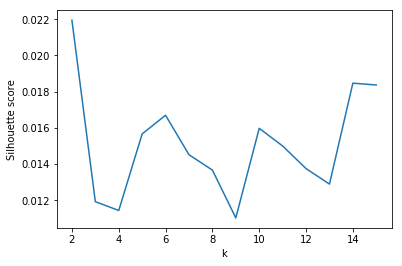

In [10]:
scores = []
for n_clusters in range(2, 16):
    print n_clusters,
    # Do clustering
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer.fit(X)
    
    # Get cluster labels
    cluster_labels = clusterer.labels_
    
    # Get silhouette score
    score = silhouette_score(X, cluster_labels)
    scores.append([n_clusters, score])
scores = np.array(scores)

fig, ax = plt.subplots()
ax.plot(scores[:, 0], scores[:, 1])
ax.set_xlabel('k')
ax.set_ylabel('Silhouette score')

In [11]:
# Do final clustering with optimal number of clusters
n_clusters = 2
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
clusterer.fit(X)
labels = clusterer.predict(X)

## Project onto 2 dimensions and plot

In [22]:
#project = PCA(n_components=2)
project = TSNE(n_components=2, random_state=1)

# Algorithms require nonsparse arrays
X_nonsparse = X.toarray()
X_2d = project.fit_transform(X_nonsparse)

# Create data frame for 2d projection
df_2d = pd.DataFrame(data=X_2d, columns=['x0', 'x1'])
df_2d['cluster'] = labels
df_2d['route_name'] = df_items['route_name']

## Plot clusters on 2d projection

In [23]:
df_2dtop = df_2d[df_2d['route_name'].isin(df_top['route_name'])]
df_2dtop

,x0,x1,cluster,route_name
96,13.158080,101.868210,0,Drunkard's Delight
123,19.641489,97.068619,0,Shockley's Ceiling
152,33.623795,103.741165,0,Something Interesting
207,41.818176,105.971672,0,Friends and Lovers
323,12.358734,89.272110,1,Bonnie's Roof


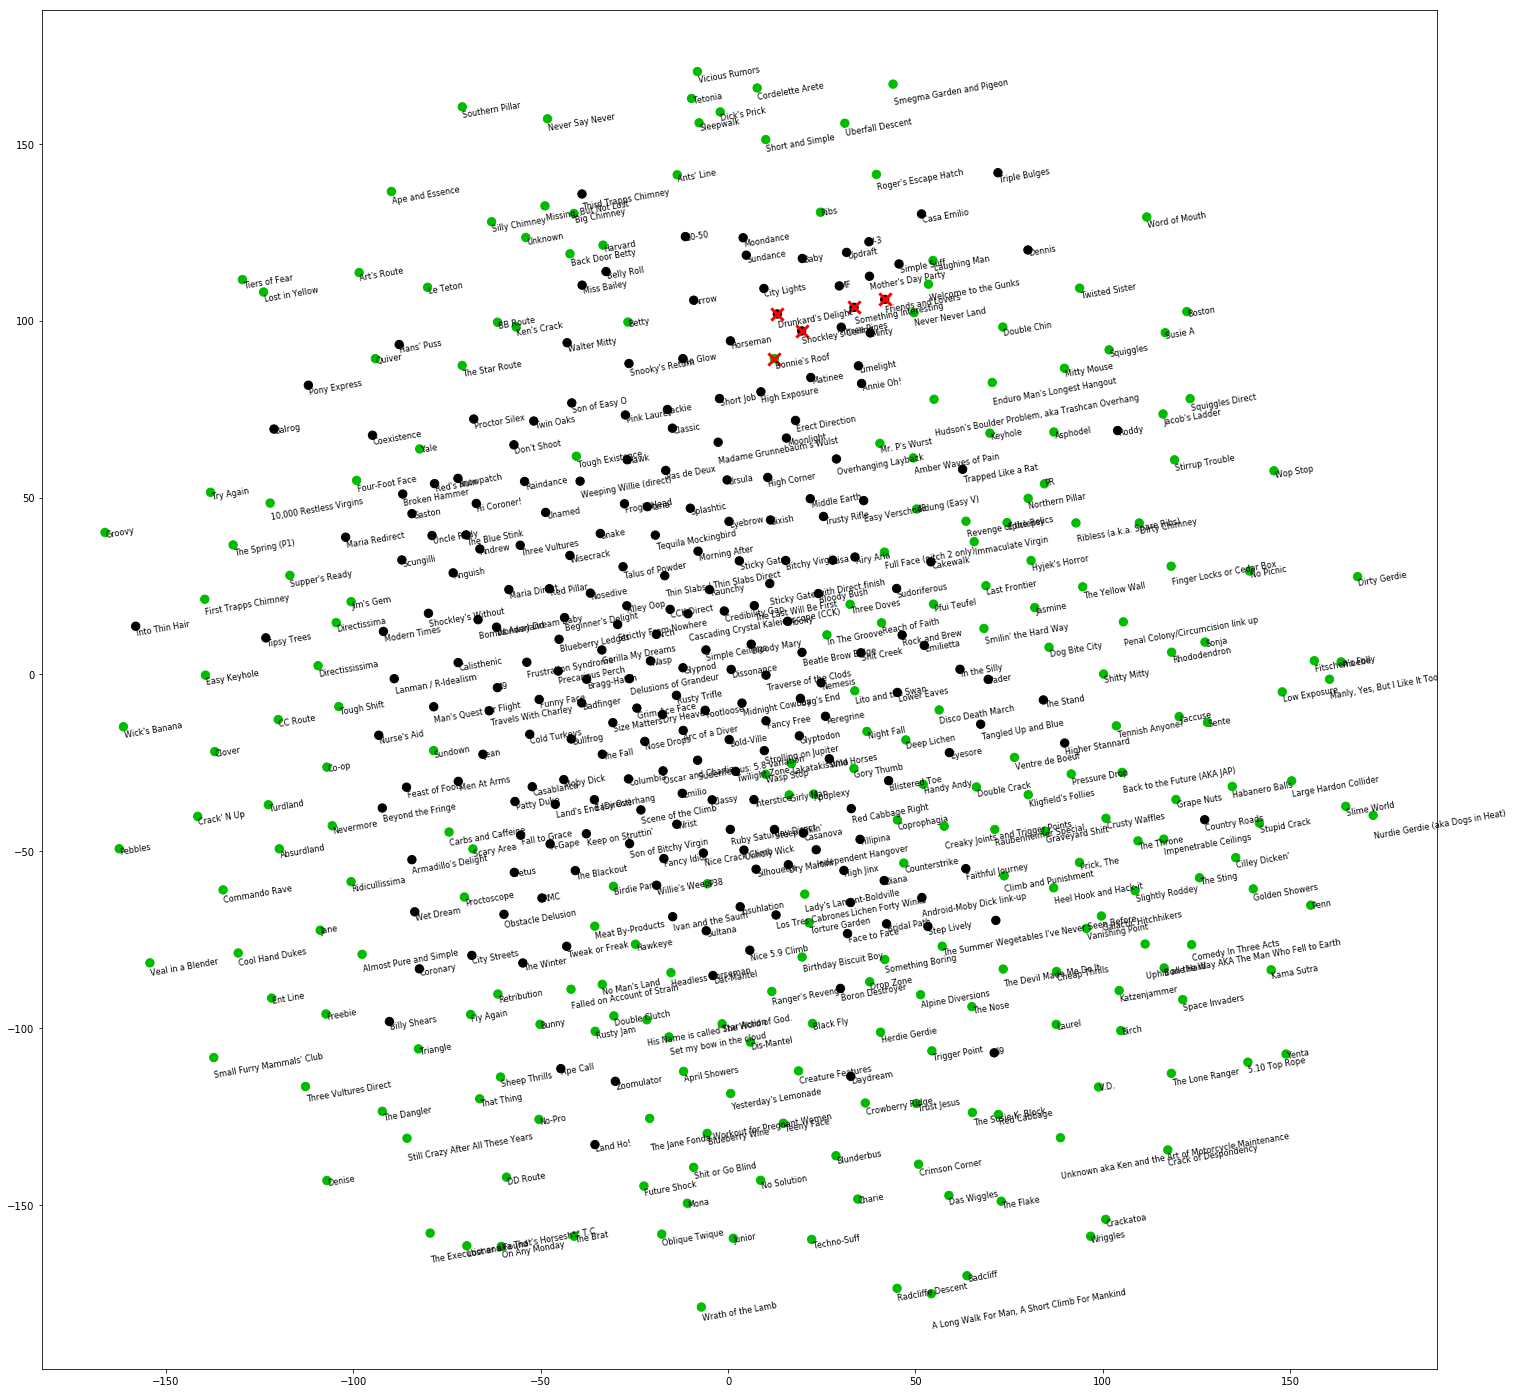

In [24]:
#df = df_2d.copy().sample(200)
df = df_2d.copy()

x0s = df['x0'].values
x1s = df['x1'].values
clusters = df['cluster'].values
names = df['route_name'].values

fig, ax = plt.subplots(figsize=(25, 25))

colors = cm.nipy_spectral(clusters.astype(float) / n_clusters)
ax.scatter(x0s, x1s, c=colors, s=70)
for i in range(len(df)):
    #name = names[i].replace(' ', '\n')
    name = names[i]
    #ax.annotate(name, (x0s[i], x1s[i]), rotation=20, fontsize=8, va='center', ha='left')
    #ax.annotate(name, (x0s[i], x1s[i]), color=colors[i], rotation=0, fontsize=8)
    ax.annotate(name, (x0s[i], x1s[i]), color='k', rotation=10, fontsize=8)
    
    
    
x0s = df_2dtop['x0'].values
x1s = df_2dtop['x1'].values
ax.scatter(x0s, x1s, c='r', marker='x', lw=3, s=150)


#fig.savefig('test.pdf')